In [46]:
import numpy as np

import pandas as pd

from keras.models import Sequential

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences

from keras.utils.np_utils import to_categorical

import re

df = pd.read_csv("Train.csv")

In [47]:
df['text'] = df['text'].str.lower()

In [48]:
import string
def remove_punct(text):
    text ="".join([char for char in text if char not in string.punctuation])
    return text
df['text'] = df['text'].apply(lambda x: remove_punct(x))
df.head()

,text,label
0,i grew up b 1965 watching and loving the thund...,0
1,when i put this movie in my dvd player and sat...,0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1


In [49]:
def tokenize(text):
    tokens =re.split('\W+',text)
    return tokens
df['text']=df['text'].apply(lambda x: tokenize(x))

In [5]:
df.head()

,text,label
0,"[i, grew, up, b, 1965, watching, and, loving, ...",0
1,"[when, i, put, this, movie, in, my, dvd, playe...",0
2,"[why, do, people, who, do, not, know, what, a,...",0
3,"[even, though, i, have, great, interest, in, b...",0
4,"[im, a, die, hard, dads, army, fan, and, nothi...",1


In [50]:
import nltk
stopwords=nltk.corpus.stopwords.words('english')
def remove_stop(tokenized_text):
    rext=[word for word in tokenized_text if word not in stopwords]
    return rext
df['text']=df['text'].apply(lambda x:remove_stop(x))
df.head()

,text,label
0,"[grew, b, 1965, watching, loving, thunderbirds...",0
1,"[put, movie, dvd, player, sat, coke, chips, ex...",0
2,"[people, know, particular, time, past, like, f...",0
3,"[even, though, great, interest, biblical, movi...",0
4,"[im, die, hard, dads, army, fan, nothing, ever...",1


In [7]:
from sklearn.metrics import precision_score,recall_score
from sklearn.model_selection import train_test_split

In [56]:
df.columns = ["text", "label"]
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['label'], test_size=0.2)


In [57]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [58]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [59]:
X_train_seq[0]

[17,
 2,
 73,
 2968,
 1159,
 3303,
 1159,
 49530,
 689,
 16,
 649,
 1188,
 536,
 3924,
 2,
 702,
 382,
 649,
 1046,
 4683,
 16,
 1094,
 1188,
 3715,
 27,
 44,
 969,
 780,
 278,
 29,
 579,
 154,
 2,
 281,
 190,
 622,
 62,
 29,
 357,
 2908,
 33,
 1635,
 96,
 374,
 702,
 2,
 10,
 25614,
 68,
 443,
 11,
 702,
 2,
 68,
 11,
 25615,
 1031,
 2]

In [60]:
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [61]:
X_train_seq_padded[0]

array([  689,    16,   649,  1188,   536,  3924,     2,   702,   382,
         649,  1046,  4683,    16,  1094,  1188,  3715,    27,    44,
         969,   780,   278,    29,   579,   154,     2,   281,   190,
         622,    62,    29,   357,  2908,    33,  1635,    96,   374,
         702,     2,    10, 25614,    68,   443,    11,   702,     2,
          68,    11, 25615,  1031,     2])

In [62]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [63]:
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          4493632   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,503,041
Trainable params: 4,503,041
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [69]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=3,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/3
1000/1000 [==============================] - 99s 95ms/step - loss: 0.1803 - accuracy: 0.9316 - precision_m: 0.9278 - recall_m: 0.9355 - val_loss: 0.3528 - val_accuracy: 0.8528 - val_precision_m: 0.8417 - val_recall_m: 0.8702
Epoch 2/3
1000/1000 [==============================] - 92s 92ms/step - loss: 0.0751 - accuracy: 0.9739 - precision_m: 0.9710 - recall_m: 0.9766 - val_loss: 0.4813 - val_accuracy: 0.8414 - val_precision_m: 0.8526 - val_recall_m: 0.8268
Epoch 3/3
1000/1000 [==============================] - 92s 92ms/step - loss: 0.0283 - accuracy: 0.9913 - precision_m: 0.9901 - recall_m: 0.9929 - val_loss: 0.6875 - val_accuracy: 0.8276 - val_precision_m: 0.8658 - val_recall_m: 0.7757


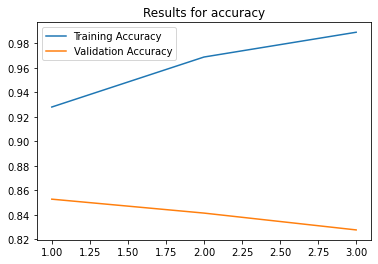

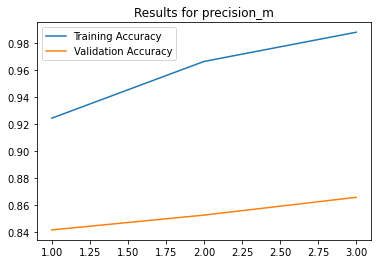

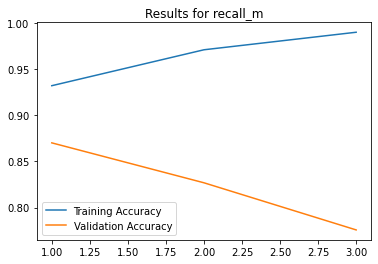

In [75]:
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()